In [4]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import utils
import datasets
import keras.backend as K
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.layers import Input, Reshape
from keras.layers import Conv2D, MaxPooling2D, Activation , Flatten, Dense
from keras.layers import RNN, LSTM, GRU, ConvLSTM2D
from keras.layers import Deconv3D,UpSampling3D, Activation

In [5]:
# some magic commands
# %load_ext autoreload
%matplotlib inline

[load_dataset] loading ShapeNet
[construct_paths] for dir ShapeNet
[fetch_renders_from_disk] in dir ./Renders
[fetch_renders_from_disk] returning 10 renders from ./Renders


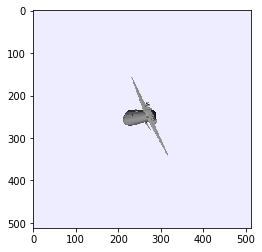

In [10]:
# load data and display random example
X=datasets.load_dataset("ShapeNet")
input_shape=X.shape[1:]
plt.imshow(random.choice(X))

In [11]:
# net parameters
conv_filter_count = [96, 128, 256, 256, 256, 256]
deconv_filter_count = [128, 128, 128, 64, 32, 2]

In [12]:
# encoder network
print(X.shape)
input_tensor=Input(shape=input_shape);
cur_tensor=input_tensor
k_s = [3,3]

for i in range(6): 
    ks=[7,7]if i is 0 else k_s  
    with K.name_scope("encoder_layer"):
        cur_tensor=Conv2D(filters=conv_filter_count[i],kernel_size= k_s)(cur_tensor)
        cur_tensor=MaxPooling2D()(cur_tensor)
        cur_tensor=Activation('relu')(cur_tensor)
    print(cur_tensor.shape)

(10, 512, 512, 3)
(?, 255, 255, 96)
(?, 126, 126, 128)
(?, 62, 62, 256)
(?, 30, 30, 256)
(?, 14, 14, 256)
(?, 6, 6, 256)


In [ ]:
# 3D-LSTM 

# construct input to 3D-LSTM cells
cur_tensor=Flatten()(cur_tensor)
print(cur_tensor.shape)
cur_tensor=Dense(1024)(cur_tensor)
print(cur_tensor.shape)
cur_tensor=Reshape([1,1024])(cur_tensor)
print(cur_tensor.shape)

# construct 3D grid of cells
cell_grid= utils.grid3D(GRU(1024),N=3)
out=[];
with K.name_scope("3D-LSTM"):
    for cell in np.nditer(cell_grid,flags=['refs_ok']):
        out.append((cell.item())(cur_tensor));
        
out=np.array(out)

In [ ]:
print(type(out[0]))
print(out.shape)
out=out.reshape([3,3,3])
print(type(out[0,0,0]))
print(out.shape)

In [ ]:
np.tan

In [ ]:
# decoder network
for i in range(6):
with K.name_scope("decoder_layer"):
    cur_tensor=Deconv3D(filters=deconv_filter_count[i],kernel_size=(3,3,3))(cur_tensor)
    cur_tensor=UpSampling3D()(cur_tensor)
    cur_tensor=Activation('relu')(cur_tensor)
    print(cur_tensor.shape)
    
print(cur_tensor.shape())

In [13]:
net = Model(input=input_tensor,output=cur_tensor)
net.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("en...)`
  """Entry point for launching an IPython kernel.


In [14]:
os.system("rm -rf ./logs/*")
tensor_board=TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
net.fit(X,np.random.rand(len(X),1,1024),epochs=1,callbacks=[tensor_board])

ValueError: Error when checking target: expected activation_6 to have 4 dimensions, but got array with shape (10, 1, 1024)